# Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import numpy as np
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf, pacf
import warnings

warnings.filterwarnings("ignore")

# Problem I
Take a prince index, the inflation, the GDP, the short-term interest rate, and the daily consumption of electricity of a developed country. You could take them from FRED or Mark Watson’s website or any other source.

## 1. 
Take a prince index, the inflation, the GDP, the short-term interest rate, and the daily consumption of electricity of a developed country. You could take them from FRED or Mark Watson’s website or any other source.

In [2]:
def load_and_preprocess_data(filename):
    df = pd.read_csv(filename)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)  
    return df


def main_1(df, name):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), dpi=120)
    fig.tight_layout(pad=6.0)
    series_name = df.columns[0]  # Assuming only one series besides the date index
    
    # Plot the series
    df[series_name].plot(ax=axes[0, 0], title=f'Original Time Series of {name}')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Value')

    # ACF of Original Series
    plot_acf(df[series_name], ax=axes[1, 0], title='ACF of Original Series')
    
    # PACF of Original Series
    lags_pacf = min(len(df) // 2 - 1, 14)
    plot_pacf(df[series_name], ax=axes[1, 1], lags=lags_pacf, title='PACF of Original Series')
    
    # First difference
    df_diff = df.diff().dropna()
    df_diff.plot(ax=axes[0, 1], title='First Difference of Series')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Value')
    
    # ACF of First Difference
    plot_acf(df_diff, ax=axes[2, 0], title='ACF of First Difference')
    
    # PACF of First Difference
    plot_pacf(df_diff, ax=axes[2, 1], lags=lags_pacf, title='PACF of First Difference')
    
    plt.show()
    
    # Descriptive Statistics
    print(f'\nDescriptive Statistics for Original Series of {name}:\n', df.describe())
    print(f'\nDescriptive Statistics for First Difference of {name} Series:\n', df_diff.describe())
    
    # Augmented Dickey-Fuller Test
    adf_test_original = adfuller(df[series_name])
    adf_test_diff = adfuller(df_diff[series_name])
    print(f"\nADF Test Statistic for Original Series of {name}: {adf_test_original[0]}")
    print(f"p-value for Original Series of {name}: {adf_test_original[1]}")
    print(f"ADF Test Statistic for First Difference of {name}: {adf_test_diff[0]}")
    print(f"p-value for First Difference of {name}: {adf_test_diff[1]}")


def format_elec_data(df):
    df["Date - Heure"] = pd.to_datetime(df["Date - Heure"], utc=True)

    # Convert to local time, assuming the timezone is CET (which is UTC+1 or UTC+2 for daylight saving time)
    df["Date - Heure"] = df["Date - Heure"].dt.tz_convert('Europe/Paris')
    
    # Extract date from datetime
    df["Date"] = df["Date - Heure"].dt.date
    
    # Group by the new Date column and sum the consumption for each day
    daily_df = df.groupby("Date").agg({"Consommation brute électricité (MW) - RTE": "sum"}).reset_index()
    daily_df['Date'] = pd.to_datetime(daily_df['Date'])
    daily_df.set_index('Date', inplace=True)
    return daily_df

### GDP

In [3]:
gdp_data = load_and_preprocess_data('nominal_gdp.csv')
gdp_data.head()

,NGDPSAXDCFRQ
DATE,
1980-01-01,108704.8
1980-04-01,111516.3
1980-07-01,114578.6
1980-10-01,116893.3
1981-01-01,120604.9


#### Plots

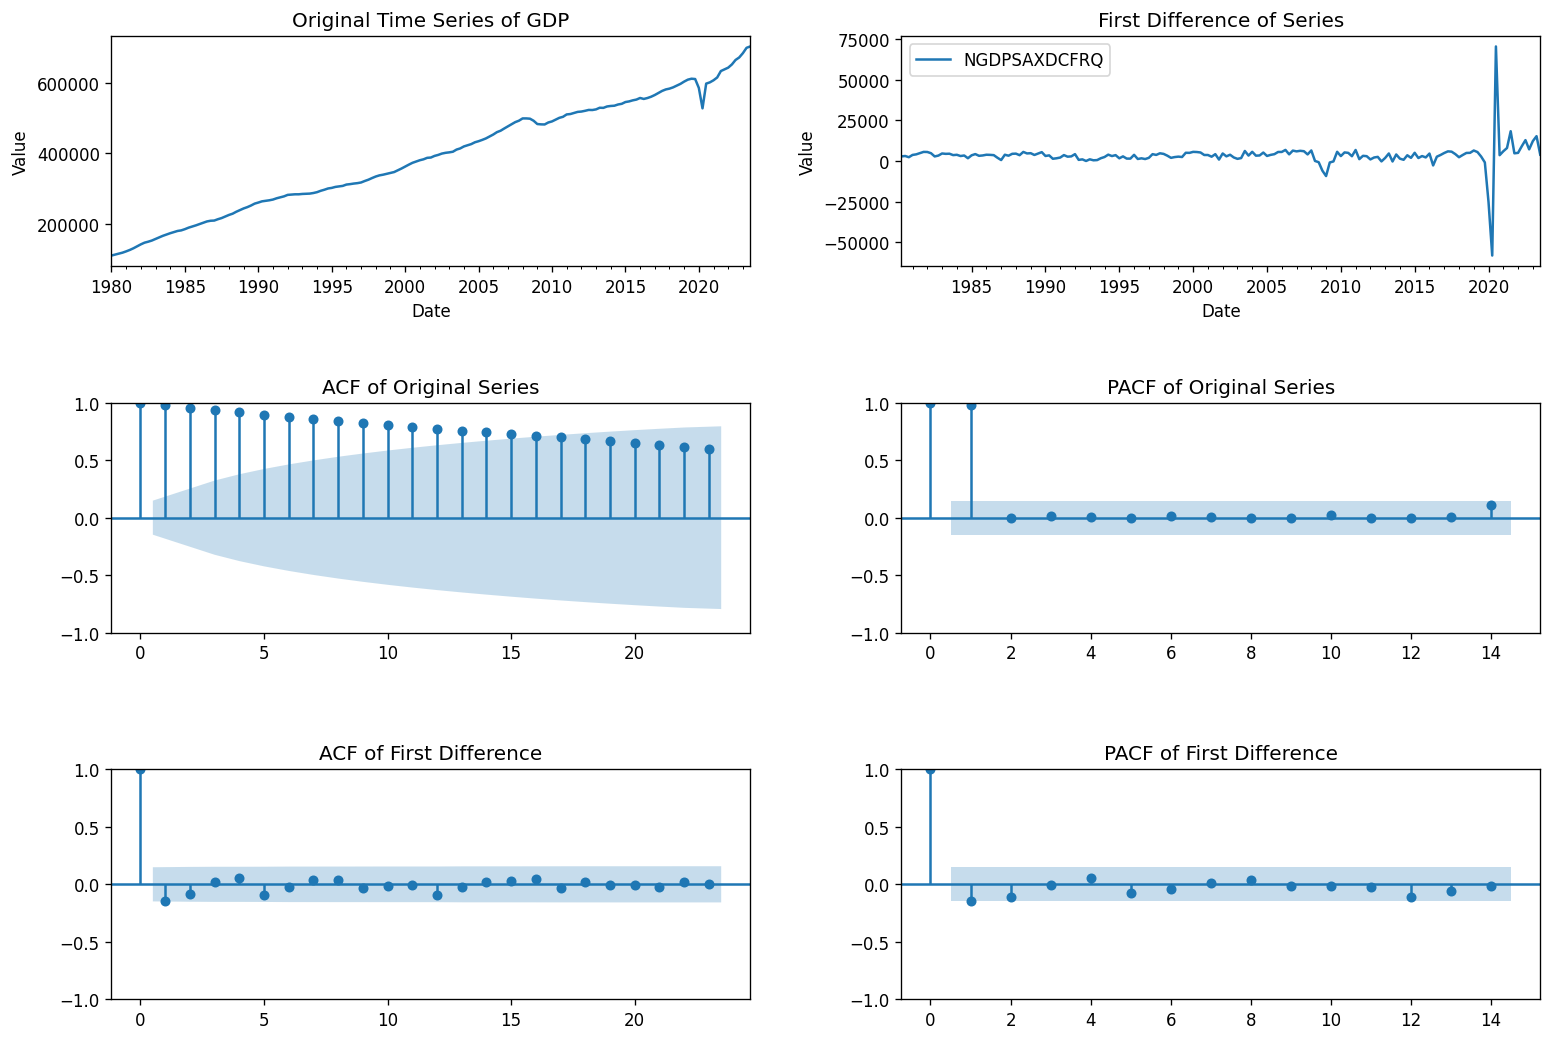


Descriptive Statistics for Original Series of GDP:
         NGDPSAXDCFRQ
count     175.000000
mean   390268.246857
std    157220.306558
min    108704.800000
25%    267353.750000
50%    388213.100000
75%    523864.650000
max    705014.700000

Descriptive Statistics for First Difference of GDP Series:
        NGDPSAXDCFRQ
count    174.000000
mean    3427.068391
std     7788.247567
min   -58242.500000
25%     2142.525000
50%     3587.750000
75%     4785.425000
max    70520.200000

ADF Test Statistic for Original Series of GDP: 0.5078161945075979
p-value for Original Series of GDP: 0.9851087370340792
ADF Test Statistic for First Difference of GDP: -10.949354335782362
p-value for First Difference of GDP: 8.878567484572884e-20


In [4]:
main_1(gdp_data, "GDP")

#### Comments

- The plot of the time series strongly suggest an increasing trend over time

- The ADF test statistic for the original series is positive, and the p-value is significantly greater than 0.05 (the typical threshold for statistical significance in such tests). This indicates that we fail to reject the null hypothesis, suggesting that the original GDP time series is non-stationary. This means that the series may have a trend, seasonality, or other structures that evolve over time rather than being constant.

- For the first-differenced series, the ADF test statistic is significantly negative, and the p-value is extremely low (practically zero for all practical purposes). This strongly suggests rejecting the null hypothesis in favor of the alternative hypothesis that the differenced series is stationary. This indicates that once we account for the changes between consecutive observations (by differencing), the resultant time series does not have any time-dependent structure like trends or seasonality.

### Price index

In [5]:
cpi_data = load_and_preprocess_data('cpi.csv')
cpi_data.head()

,FRACPIALLMINMEI
DATE,
1960-01-01,9.797457
1960-02-01,9.820050
1960-03-01,9.820050
1960-04-01,9.835111
1960-05-01,9.812519


#### Plots

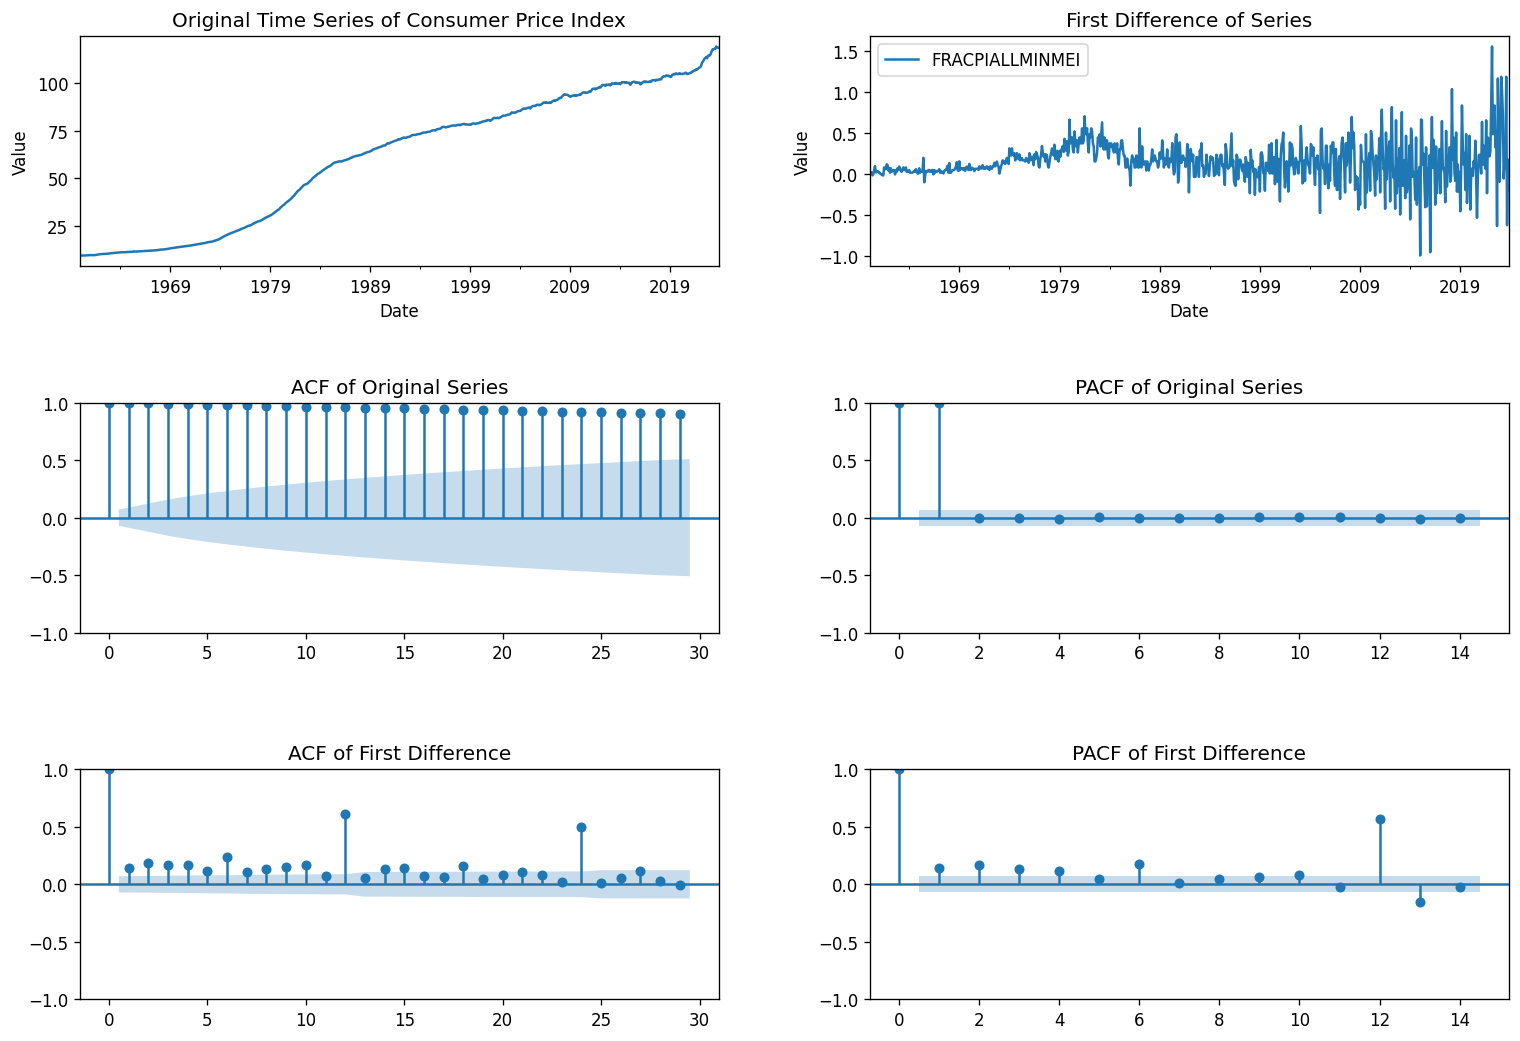


Descriptive Statistics for Original Series of Consumer Price Index:
        FRACPIALLMINMEI
count       767.000000
mean         61.222645
std          34.226714
min           9.797457
25%          23.256459
50%          70.440000
75%          91.805000
max         118.890000

Descriptive Statistics for First Difference of Consumer Price Index Series:
        FRACPIALLMINMEI
count       766.000000
mean          0.141557
std           0.237738
min          -1.000000
25%           0.030031
50%           0.110271
75%           0.250000
max           1.550000

ADF Test Statistic for Original Series of Consumer Price Index: -0.1684460330366885
p-value for Original Series of Consumer Price Index: 0.9421797365834444
ADF Test Statistic for First Difference of Consumer Price Index: -3.214646766493181
p-value for First Difference of Consumer Price Index: 0.019152367449662137


In [6]:
main_1(cpi_data, 'Consumer Price Index')

#### Comments

- We can see an increasing trend over time, 
- The first difference plot is very noisy
- The ADF test statistic for the original CPI series is close to zero and negative, but the p-value is very high (much greater than 0.05). This means there's strong evidence that the series is non-stationary, likely containing a time-dependent structure such as a trend.
- For the first-differenced series, the ADF test statistic is significantly more negative, and the p-value is below the typical 0.05 threshold for statistical significance. This suggests that the differenced series is stationary, indicating that differencing has effectively removed the time-dependent structure from the data.

### Inflation

In [7]:
inflation_data = load_and_preprocess_data('inflation.csv')
inflation_data.head()

,FPCPITOTLZGFRA
DATE,
1960-01-01,4.139936
1961-01-01,2.400461
1962-01-01,5.331280
1963-01-01,4.999153
1964-01-01,3.211192


#### Plots

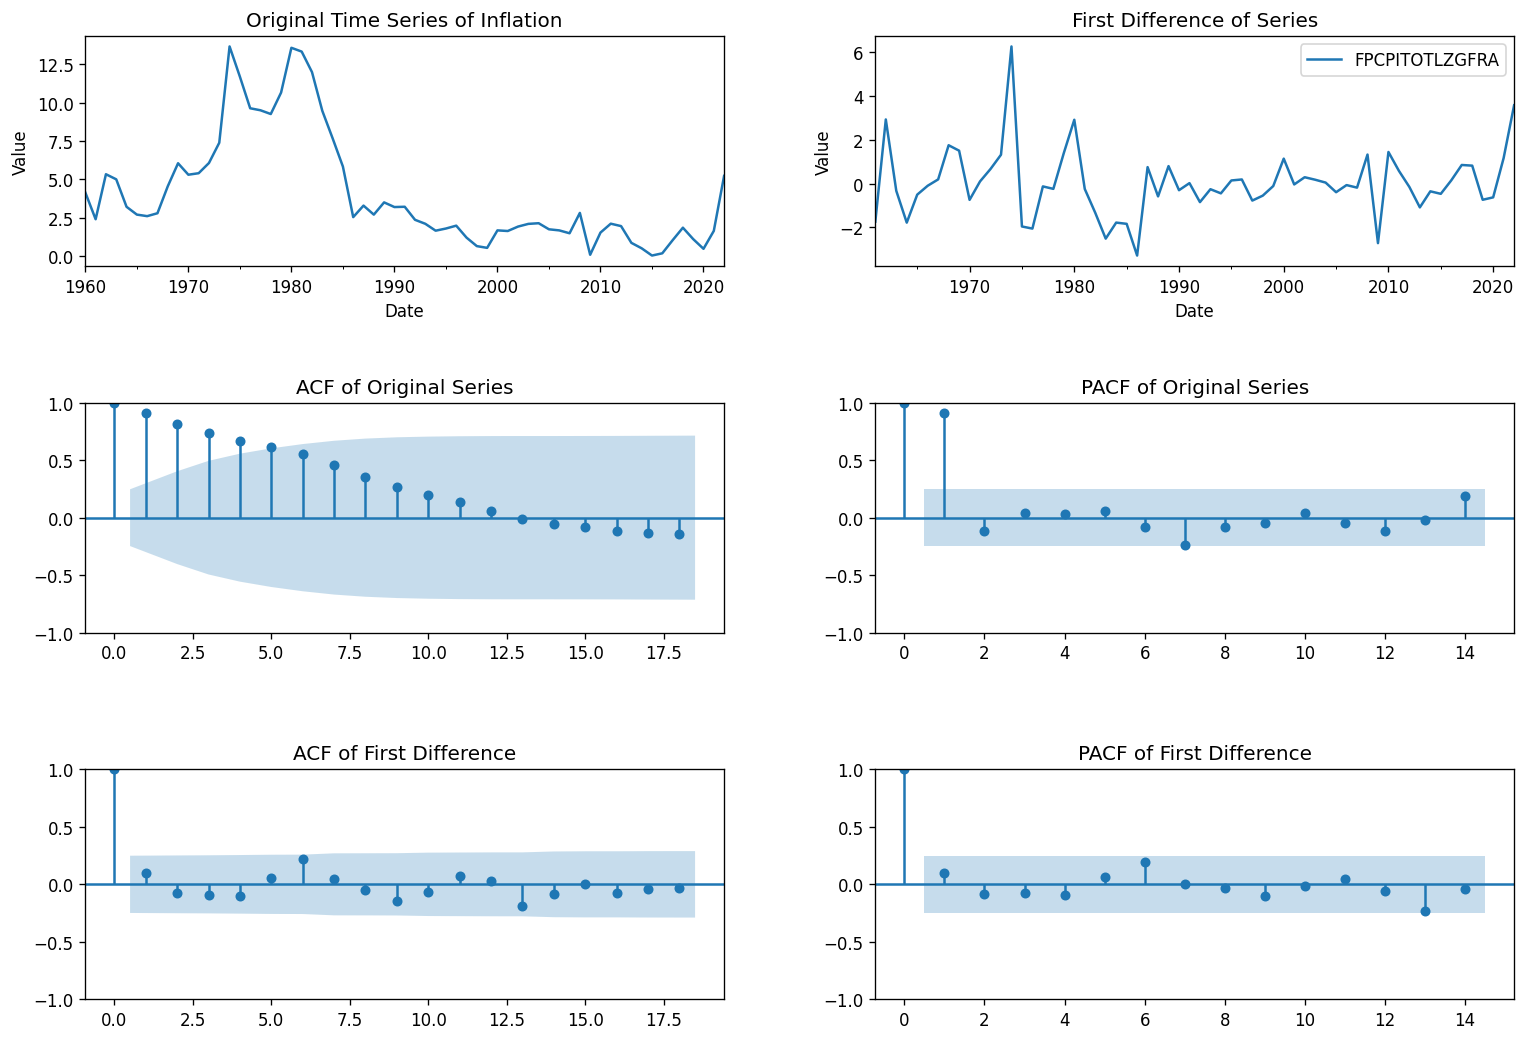


Descriptive Statistics for Original Series of Inflation:
        FPCPITOTLZGFRA
count       63.000000
mean         4.057410
std          3.658403
min          0.037514
25%          1.665320
50%          2.602001
75%          5.364399
max         13.649317

Descriptive Statistics for First Difference of Inflation Series:
        FPCPITOTLZGFRA
count       62.000000
mean         0.017459
std          1.524360
min         -3.292574
25%         -0.620838
50%         -0.122463
75%          0.729150
max          6.268716

ADF Test Statistic for Original Series of Inflation: -1.6208899976681996
p-value for Original Series of Inflation: 0.4722627369159214
ADF Test Statistic for First Difference of Inflation: -6.6493731626703925
p-value for First Difference of Inflation: 5.167278407629681e-09


In [8]:
main_1(inflation_data, "Inflation")

#### Comments

- The plot of the time series suggests it is stationary
- However the ADF test statistic for the original inflation series is negative but not enough to conclude stationarity, as indicated by the high p-value (greater than 0.05). This suggests that the original series is likely non-stationary
- For the first-differenced series, the ADF test statistic is much more negative, and the p-value is extremely low, practically zero. This strongly indicates that the first-differenced series is stationary, meaning that differencing the data has effectively removed the time-dependent structure.

### Short-term interest rate

In [9]:
stir_data = load_and_preprocess_data('ir.csv')
stir_data.head()

,IR3TIB01FRM156N
DATE,
1970-01-01,10.35
1970-02-01,9.86
1970-03-01,9.55
1970-04-01,8.95
1970-05-01,9.02


#### Plots

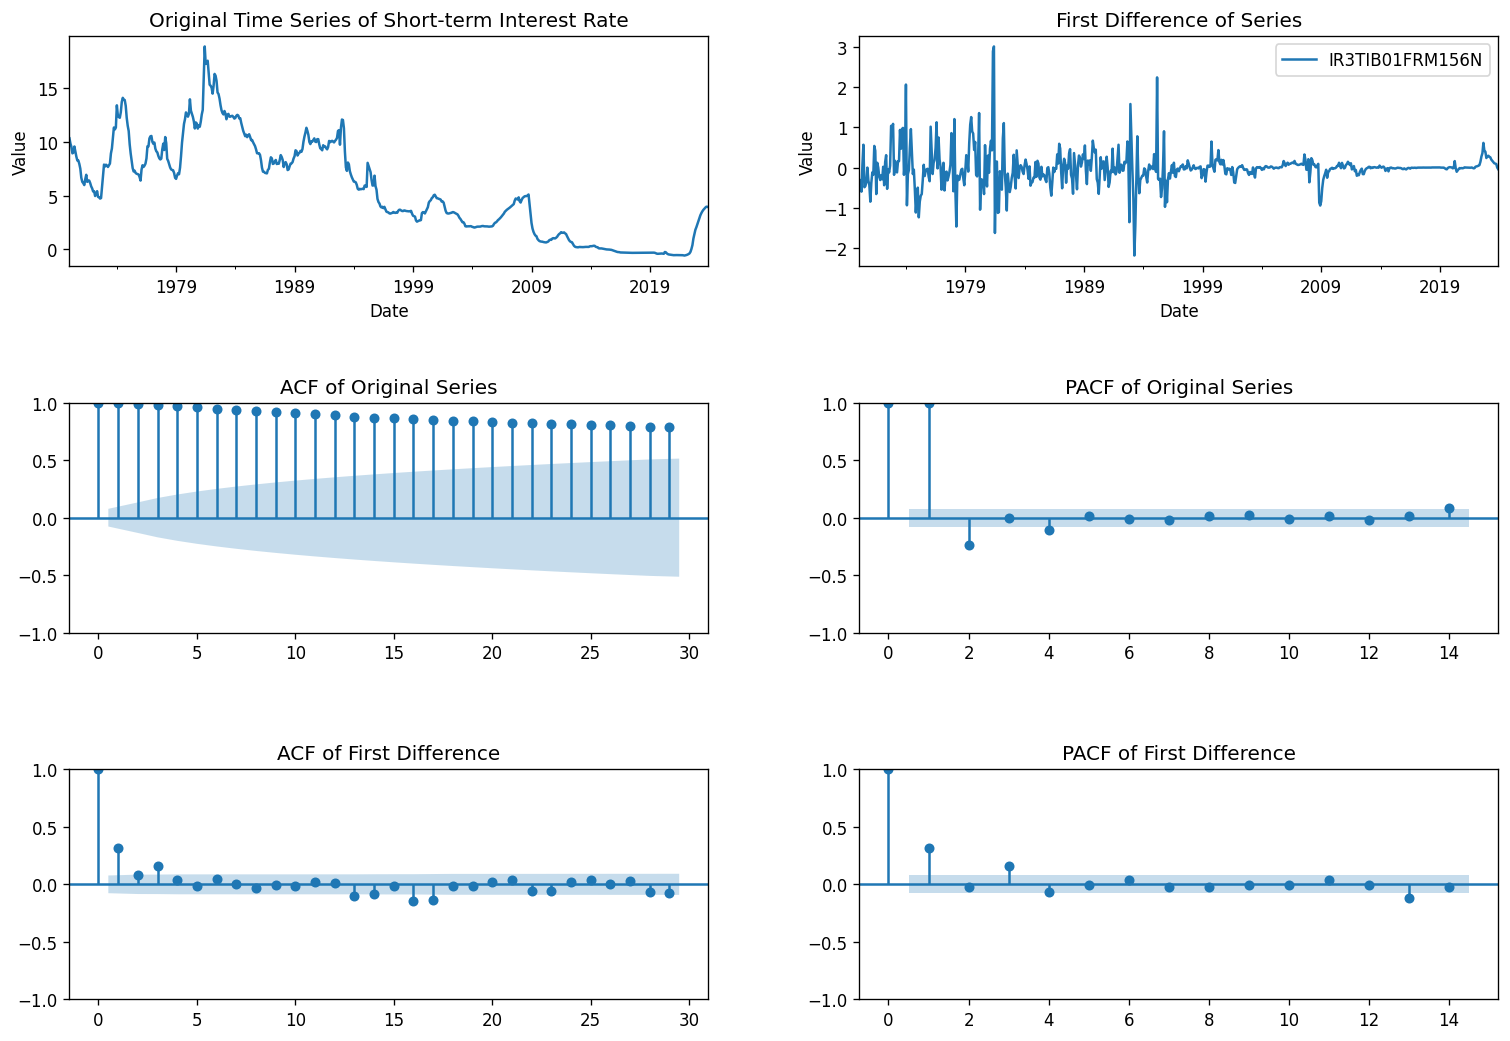


Descriptive Statistics for Original Series of Short-term Interest Rate:
        IR3TIB01FRM156N
count       648.000000
mean          5.510994
std           4.468329
min          -0.582000
25%           1.592175
50%           4.773900
75%           9.097875
max          18.920000

Descriptive Statistics for First Difference of Short-term Interest Rate Series:
        IR3TIB01FRM156N
count       647.000000
mean         -0.009923
std           0.416375
min          -2.192400
25%          -0.139650
50%          -0.005100
75%           0.077100
max           3.020000

ADF Test Statistic for Original Series of Short-term Interest Rate: -1.8325783008835552
p-value for Original Series of Short-term Interest Rate: 0.3644115820582855
ADF Test Statistic for First Difference of Short-term Interest Rate: -10.863717124734935
p-value for First Difference of Short-term Interest Rate: 1.4249110392897714e-19


In [10]:
main_1(stir_data, 'Short-term Interest Rate')

#### Comments

- The time series does not look stationary on the plot
- The ADF test statistic for the original series of Short-term Interest Rate is negative, yet the p-value is significantly above 0.05. This suggests that we cannot reject the null hypothesis of non-stationarity, implying the original series likely contains a time-dependent structure
- For the first-differenced series, the ADF test statistic is deeply negative, and the p-value is extremely low, practically zero. This strongly suggests rejecting the null hypothesis in favor of the alternative hypothesis, indicating the first-differenced series is stationary.

### Electricity Daily Consumption

In [11]:
elec_data = format_elec_data(pd.read_csv('consommation-quotidienne-brute.csv', sep=';'))

elec_data.head()

,Consommation brute électricité (MW) - RTE
Date,
2012-01-01,2472864
2012-01-02,2912789
2012-01-03,3252554
2012-01-04,3265378
2012-01-05,3319532


#### Plots

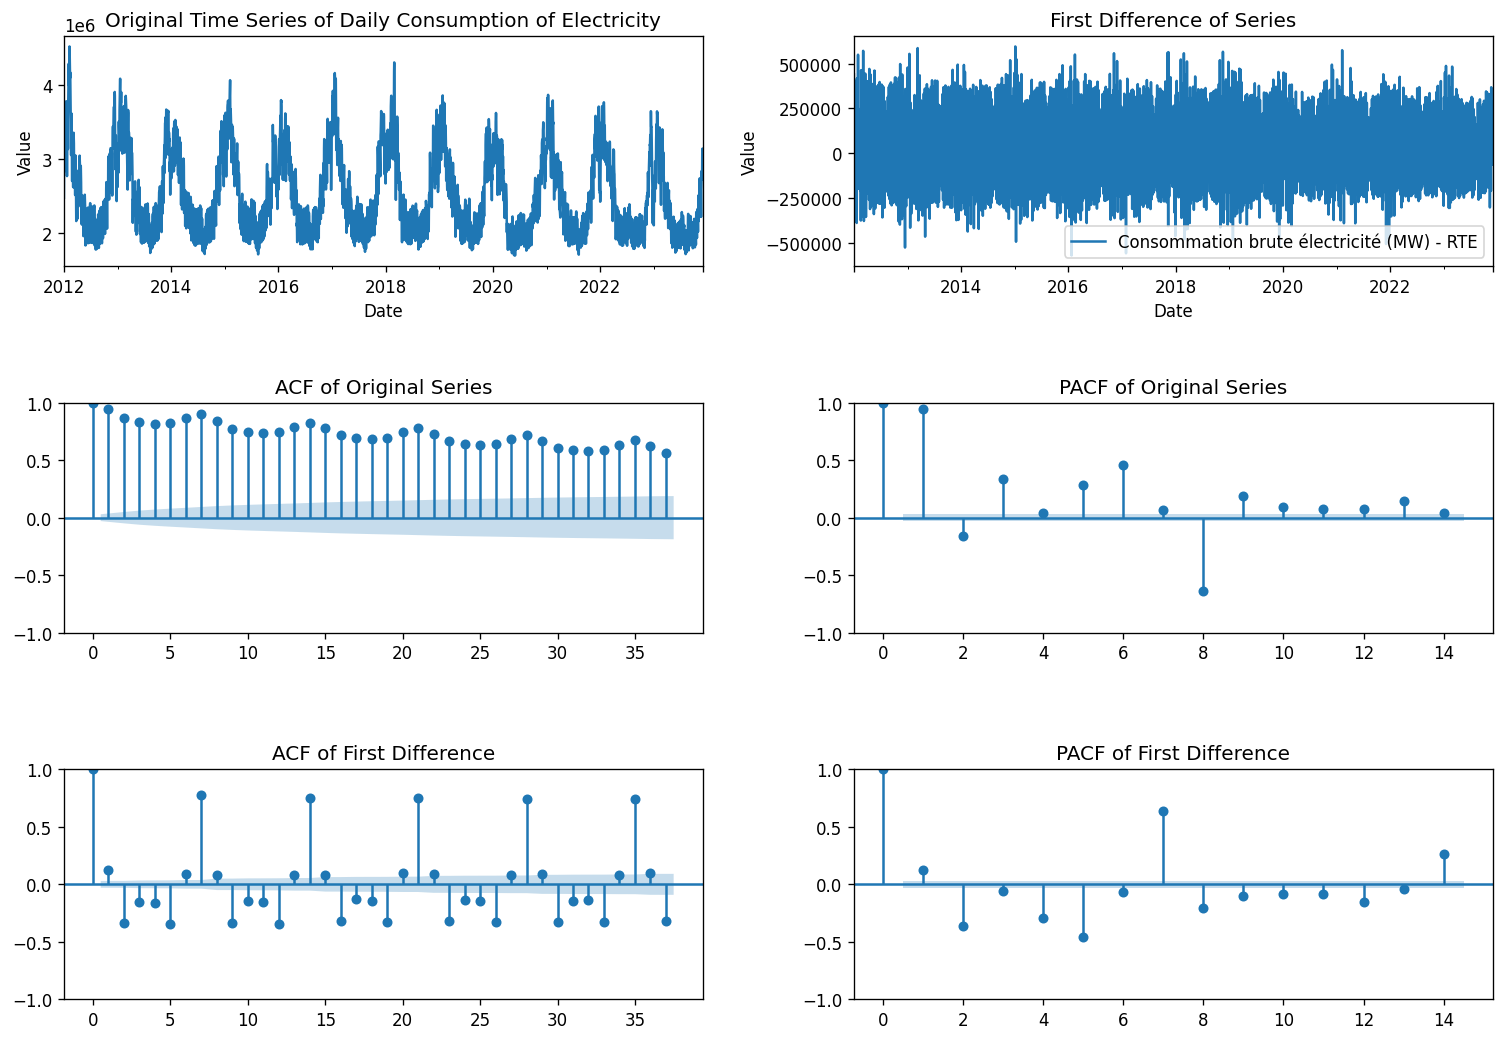


Descriptive Statistics for Original Series of Daily Consumption of Electricity:
        Consommation brute électricité (MW) - RTE
count                               4.352000e+03
mean                                2.561585e+06
std                                 5.241475e+05
min                                 1.692364e+06
25%                                 2.172954e+06
50%                                 2.388416e+06
75%                                 2.957269e+06
max                                 4.516388e+06

Descriptive Statistics for First Difference of Daily Consumption of Electricity Series:
        Consommation brute électricité (MW) - RTE
count                                4351.000000
mean                                  139.878419
std                                180429.329967
min                               -568887.000000
25%                               -110721.000000
50%                                 -7151.000000
75%                                 69545.50

In [12]:
main_1(elec_data, 'Daily Consumption of Electricity')

#### Comments

- This time series shows a cyclic trend, which is normal since the electricity consumption vary along with the season.
- The ADF test statistic for the original series is significantly negative, and the p-value is well below the common threshold of 0.05. This indicates that we can reject the null hypothesis of the presence of a unit root, suggesting the series is stationary. Even though electricity consumption typically exhibits seasonal cycles, the test results imply that, aside from seasonality, the series does not have a time-dependent structure like a trend that would make it non-stationary.
- For the first-differenced series, the ADF test statistic is extremely negative, and the p-value is practically zero. This further confirms the absence of a unit root in the differenced series, indicating it is stationary. The first differencing would typically be used to remove any linear trend or seasonality, but given the original series already appears stationary, this step emphasizes the removal of any subtle non-stationary components that might not be immediately apparent.
- While the series exhibits short-term fluctuations, its statistical properties like the mean and variance do not change over time.
- This shows the difference between a strictly stationary process and a weakly stationary process (like this one that may look non-stationary but is not)

## 2.
Find the best AR(p) process for each of the variables.

To find the optimal p, we can start by a visual inspection: we count the number of lags in the PACF plots that are far away from 0.

- 2 for GDP
- 2 for Consumer Price Index
- 4 for Inflation
- 3 for the Short-term Interest Rate
- 6 for the Electricity Consumption

Note that this is only a visual method, we will find the optimal p analytically.

In [13]:
def find_optimal_p(df):
    aic_values = {}
    col_name = df.columns[0]
    try:
        df.index.freq = 'QS-OCT'
    except:
        try:
            df.index.freq = 'MS'
        except:
            try:
                df.index.freq = 'YS-JAN'
            except:
                df.index.freq = 'D'
    for p in range(1, 30):
        model = AutoReg(df[col_name], lags=p).fit()
        aic_values[p] = model.aic
    best_p = min(aic_values, key=aic_values.get)
    print(f"The best AR(p) model is with p={best_p}, having the lowest AIC of {aic_values[best_p]}")
    return best_p

def find_optimal_p(df, seasonal=False):
    col_name = df.columns[0]
    d=1 if not seasonal else 0
    auto_model = auto_arima(df[col_name], 
                        start_p=1, max_p=15, 
                        start_q=0, max_q=0, # Since we're looking for AR(p), set q=0
                        d=d, # Assuming data is already stationary; otherwise adjust d accordingly
                        seasonal=seasonal, # Assuming no seasonality; adjust if needed
                        trace=False, # Prints model fitting information
                        error_action='ignore', # Don't want to know if an order does not work
                        suppress_warnings=True, # Suppress convergence warnings
                        stepwise=True, # Stepwise search to find the best model
                        information_criterion='aic' # Criterion to select the best model
                       )
    best_p = auto_model.order[0]
    print(f"The best AR(p) model is AR({best_p}).")

    return best_p


### GDP

In [14]:
p_gdp = find_optimal_p(gdp_data)

The best AR(p) model is AR(0).


### Price Index

In [15]:
p_cpi = find_optimal_p(cpi_data)

The best AR(p) model is AR(4).


### Inflation

In [16]:
p_inflation = find_optimal_p(inflation_data)

The best AR(p) model is AR(0).


### Short-term Interest Rate

In [17]:
p_ir = find_optimal_p(stir_data)

The best AR(p) model is AR(1).


### Electricity Daily Consumption

In [18]:
p_elec = find_optimal_p(elec_data, True)

The best AR(p) model is AR(5).


## 3. 
Provide 1-step and 3-step ahead forecasts for each variable.

In [19]:
def forecasts(df, best_p):
    # Fit the AR model to the entire dataset
    col = df.columns[0]
    model = AutoReg(df[col], lags=best_p).fit()
    forecast_1_step = model.forecast(steps=1)
    
    forecast_3_step = model.forecast(steps=3)
    
    print("1-step ahead forecast:", forecast_1_step)
    print("3-steps ahead forecast:", forecast_3_step)

### GDP

In [20]:
forecasts(gdp_data, p_gdp)

1-step ahead forecast: 2023-10-01    390268.246857
Freq: QS-OCT, dtype: float64
3-steps ahead forecast: 2023-10-01    390268.246857
2024-01-01    390268.246857
2024-04-01    390268.246857
Freq: QS-OCT, dtype: float64


### Price Index

In [21]:
forecasts(cpi_data, p_cpi)

1-step ahead forecast: 2023-12-01    118.247831
Freq: MS, dtype: float64
3-steps ahead forecast: 2023-12-01    118.247831
2024-01-01    118.338633
2024-02-01    118.419696
Freq: MS, dtype: float64


### Inflation

In [22]:
forecasts(inflation_data, p_inflation)

1-step ahead forecast: 2023-01-01    4.05741
Freq: YS-JAN, dtype: float64
3-steps ahead forecast: 2023-01-01    4.05741
2024-01-01    4.05741
2025-01-01    4.05741
Freq: YS-JAN, dtype: float64


### Short-term Interest Rate

In [23]:
forecasts(stir_data, p_ir)

1-step ahead forecast: 2024-01-01    3.928227
Freq: MS, dtype: float64
3-steps ahead forecast: 2024-01-01    3.928227
2024-02-01    3.926463
2024-03-01    3.924708
Freq: MS, dtype: float64


### Electricity Daily Consumption

In [24]:
forecasts(elec_data, p_elec)

1-step ahead forecast: 2023-12-01    2.931038e+06
Freq: D, dtype: float64
3-steps ahead forecast: 2023-12-01    2.931038e+06
2023-12-02    2.929467e+06
2023-12-03    2.953747e+06
Freq: D, dtype: float64


# Problem II

In [25]:
nvidia_data = pd.read_csv('nvidia-stock.csv')
nvidia_data.head(2)

,Date,Close/Last,Volume,Open,High,Low
0,02/22/2024,$785.38,86509970,$750.25,$785.75,$742.20
1,02/21/2024,$674.72,69029810,$680.06,$688.88,$662.48


We will observe only the Close/Last variable.

In [26]:
nvidia_data = nvidia_data[['Date', 'Close/Last']]
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])
nvidia_data.set_index('Date', inplace=True)
nvidia_data['Close/Last'] = pd.to_numeric(nvidia_data['Close/Last'].str.replace('$', ''))
nvidia_data.head(2)

,Close/Last
Date,
2024-02-22,785.38
2024-02-21,674.72


## 1.
Explain why it is better to work with (daily) log-returns.

It is often more convenient to work with daily logarithmic returns rather than raw price data because they have several desirable statistical properties that make them easier to analyze and model. Specifically:

-  Log-returns are more likely to exhibit stationary properties. Since log-returns tend to stabilize variance and exhibit less skewness and kurtosis compared to simple returns, they are more amenable to modeling with linear time series techniques, such as ARMA models.
-  Financial time series often embody multiplicative processes, where prices today are a result of a percentage change applied to yesterday's prices. Log-returns directly represent these percentage changes in a way that is additive, which aligns with the multiplicative nature of asset price movements.
-  Financial time series often exhibit volatility clustering, where high-volatility events tend to be followed by high-volatility events, and low by low. Log-returns, due to their normalization effect, can make such patterns more evident and easier to model.
-  Log-returns can be summed over time to obtain the cumulative return over a period, facilitating the analysis of returns over different time scales. This property is particularly useful in time series analysis, where we might need to aggregate daily returns into monthly or annual returns, or vice versa, to study seasonal effects, long-term trends, or to adjust the granularity of the analysis.

## 2.


In [27]:
nvidia_data['Log-Returns'] = np.log(nvidia_data['Close/Last'] / nvidia_data['Close/Last'].shift(-1))
nvidia_data.tail()

,Close/Last,Log-Returns
Date,,
2014-02-28,4.5950,-0.006508
2014-02-27,4.6250,-0.011287
2014-02-26,4.6775,-0.001602
2014-02-25,4.6850,-0.009031
2014-02-24,4.7275,NaN


In [94]:
def descriptive_statistics_log_returns(df):
    log_returns = df['Log-Returns'].dropna()
    
    mean = log_returns.mean()
    variance = log_returns.var()
    skewness = skew(log_returns)
    kurt = kurtosis(log_returns, fisher=True)
    
    acf_values = acf(log_returns, nlags=5, fft=True)
    pacf_values = pacf(log_returns, nlags=5)
    
    return {
        "Mean": mean,
        "Variance": variance,
        "Skewness": skewness,
        "Kurtosis": kurt,
        "ACF": acf_values,
        "PACF": pacf_values
    }

In [95]:
descriptive_stats = descriptive_statistics_log_returns(nvidia_data)
descriptive_stats

{'Mean': 0.0020321030029959684,
 'Variance': 0.0008529043167838703,
 'Skewness': 0.2708059885238492,
 'Kurtosis': 8.010386699674818,
 'ACF': array([ 1.        , -0.06412865,  0.02140111,  0.00276055, -0.0044299 ,
         0.02450937]),
 'PACF': array([ 1.        , -0.06415414,  0.01737389,  0.00525184, -0.00432397,
         0.02395187])}

- The average daily log-return is positive (0.2\%), indicating that, on average, the value of NVIDIA's stock has grown each day during the period analyzed. This positive mean suggests an overall upward trend in the stock price.
- The variance indicates the variability or volatility of the daily log-returns from the mean. A variance of this magnitude (0.09\%) suggests that there has been moderate volatility in NVIDIA's stock prices during the period.
- Skewness measures the asymmetry of the distribution of returns. A skewness value closer to zero suggests a more symmetric distribution of returns. A value of 0.27 indicates a slight right skew, meaning there are more instances of returns exceeding the mean than falling below it. However, the skew is relatively mild, suggesting that the distribution of returns is not far from normal in terms of asymmetry.
- Kurtosis measures the "tailedness" of the distribution of returns. A kurtosis greater than 3 (which indicates a normal distribution) suggests a leptokurtic distribution, which has fatter tails. A kurtosis of 8.01 is significantly higher than 3, indicating a high likelihood of extreme returns (both positive and negative) compared to a normal distribution. This implies that investors could occasionally experience unusually large gains or losses.
- The ACF values indicate how the log-returns correlate with themselves across different lags. The values provided suggest that there is very little autocorrelation in the log-returns, with the first lag showing a slight negative autocorrelation (-0.06) and the subsequent lags hovering around zero. This lack of strong autocorrelation suggests that past returns are not a reliable predictor of future returns, a characteristic consistent with the efficient market hypothesis for stock prices.
- The PACF values, similar to the ACF, show the correlation of the series with its own lagged values, controlling for the values of the time series at all shorter lags. The PACF values also indicate minimal correlation, with values close to zero after the first lag. This further supports the notion that returns are largely unpredictable based on past values alone.

## 3.
Find the best AR model of the data.

In [35]:
log_returns = nvidia_data['Log-Returns'].dropna()

# Check for stationarity
adf_test = adfuller(log_returns)
print(f"\nADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
# Determine the lag length for the AR model
# We'll start with a maximum lag of 5 based on the ACF and PACF provided and refine from there
max_lag = 5
best_aic = np.inf
best_lag = None

# Iterate over a range of possible lag values
for lag in range(1, max_lag + 1):
    model = AutoReg(log_returns, lags=lag).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_lag = lag

# Refit the model using the best lag
best_model_fit = AutoReg(log_returns, lags=best_lag).fit()

print(f"The best AR model of the log-returns is AR({best_lag})")


ADF Test Statistic: -17.875207085858545
p-value: 3.0169842823385467e-30
The best AR model of the log-returns is AR(1)


## 4.
Provide diagnostics.

### Residual Analysis
Evaluating the residuals of the model to check if they behave like white noise.

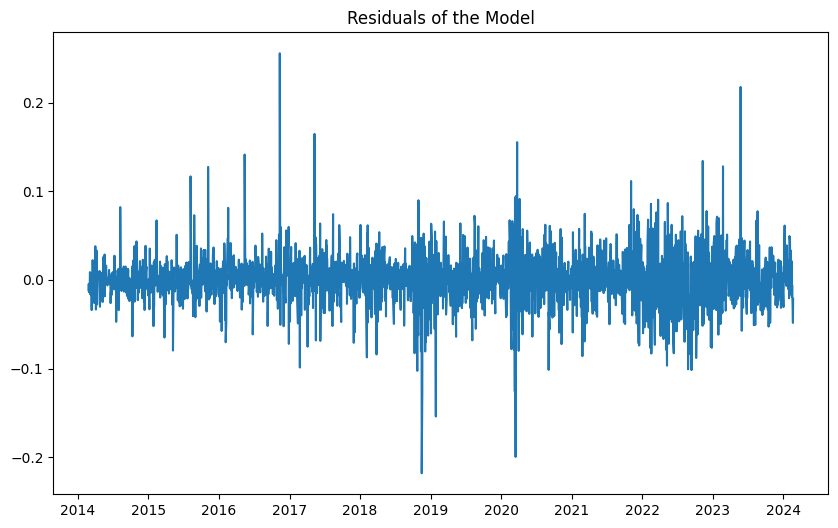

In [36]:
residuals = best_model_fit.resid
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Model')
plt.show()

The residuals look like a white noise process.

### Stationarity of Residuals

In [49]:
adf_result = adfuller(residuals)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("The residuals are stationary, suggesting the model has captured underlying trends and seasonality adequately.")
else:
    print("The residuals are not stationary, indicating the model may not have captured all underlying trends and seasonality.")

ADF Statistic: -17.811618
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The residuals are stationary, suggesting the model has captured underlying trends and seasonality adequately.


### Normality of Residuals

#### Histogram of residuals

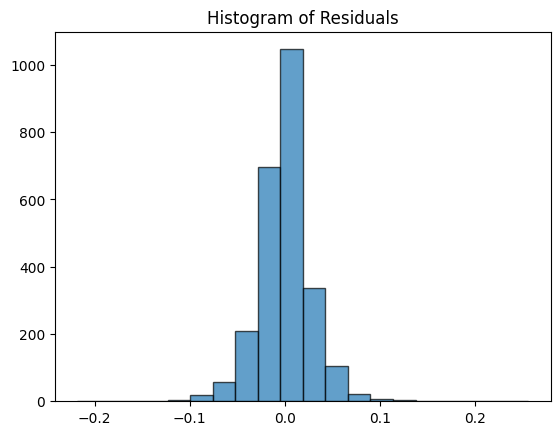

In [53]:
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.show()

#### Q-Q plot of residuals

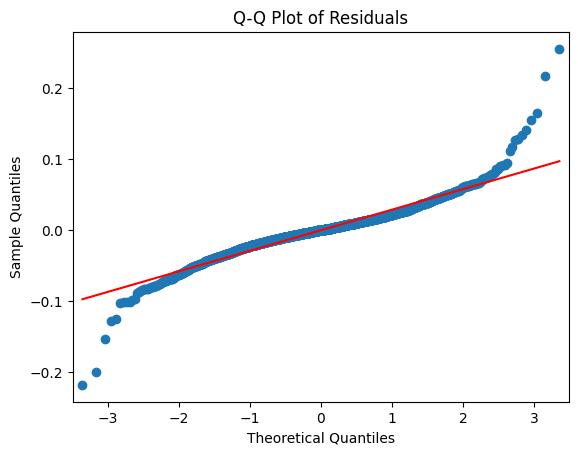

In [54]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_white
from scipy.stats import jarque_bera
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

- The lower tail of the plot shows that the sample quantiles are higher than the theoretical quantiles of the normal distribution, indicating that the data has heavier tails than a normal distribution (i.e., it has more extreme negative values than expected under normality).
- The upper tail  of the plot deviates above the line, which suggests that the data also has heavier tails on the positive side, meaning there are more extreme positive values than would be expected under normality.

These deviations suggest that the residuals are not perfectly normally distributed, particularly with evidence of heavier tails, we can test it.

In [75]:
jb_value, jb_pvalue = jarque_bera(residuals)
print(f'Jarque-Bera test p-value: {jb_pvalue}')

Jarque-Bera test p-value: 0.0


This p-value suggests that the residuals do not follow a normal distribution.

### ACF and PACF of Residuals

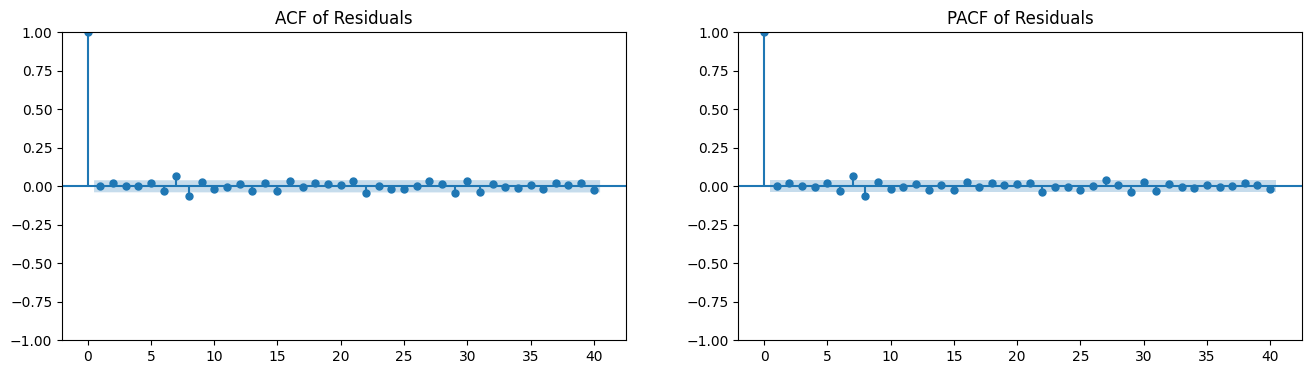

In [47]:
fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(residuals, ax=ax[0], lags=40, title='ACF of Residuals')
plot_pacf(residuals, ax=ax[1], lags=40, title='PACF of Residuals')
plt.show()

It seems that there is no autocorrelation among the residuals. We can perform a test to assess this.

In [81]:
pvalue = acorr_ljungbox(residuals, lags=[10], return_df=True).lb_pvalue
print(f'Ljung-Box test p-value: {list(pvalue)[0]}')

Ljung-Box test p-value: 0.001001256626280272


The very small p-value leads us to rejet the null hypothesis, i.e. we can conclude that there is significant evidence of autocorrelation in the residuals at one or more of the lags up to lag 10.

## 5.
Define the variable $z_t = 1$ when the return is positive, and $z_t = 0$. Do the same work (that you did for the return) for the process $z_t$.

In [86]:
nvidia_data['z'] = (nvidia_data['Log-Returns'] > 0).astype(int)
nvidia_data.head()

,Close/Last,Log-Returns,z
Date,,,
2024-02-22,785.38,0.151870,1
2024-02-21,674.72,-0.028923,0
2024-02-20,694.52,-0.044508,0
2024-02-16,726.13,-0.000620,0
2024-02-15,726.58,-0.016949,0


### Descriptive Statistics

In [87]:
print(nvidia_data['z'].describe())

count    2517.000000
mean        0.541518
std         0.498372
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: z, dtype: float64


54\% of the log-returns are positive.

In [102]:
zt = nvidia_data['z'].dropna()

mean = log_returns.mean()
variance = log_returns.var()
skewness = skew(log_returns)
kurt = kurtosis(log_returns, fisher=True)

acf_values = acf(log_returns, nlags=5, fft=True)
pacf_values = pacf(log_returns, nlags=5)

{
    "Mean": mean,
    "Variance": variance,
    "Skewness": skewness,
    "Kurtosis": kurt,
    "ACF": acf_values,
    "PACF": pacf_values
}

{'Mean': 0.0020321030029959684,
 'Variance': 0.0008529043167838703,
 'Skewness': 0.2708059885238492,
 'Kurtosis': 8.010386699674818,
 'ACF': array([ 1.        , -0.06412865,  0.02140111,  0.00276055, -0.0044299 ,
         0.02450937]),
 'PACF': array([ 1.        , -0.06415414,  0.01737389,  0.00525184, -0.00432397,
         0.02395187])}

- The average value of $z_t$ is approximately 0.002, which is very close to 0. This suggests that positive returns are very rare over the period analyzed.
- The skewness value of approximately 0.271 indicates a slight rightward skew in the distribution of $z_t$. This means there are slightly more non-positive returns (0) than positive returns (1), but the distribution is relatively symmetrical.
- The kurtosis value of approximately 8.01 suggests a leptokurtic distribution. This means the distribution of $z_t$ has heavier tails and a sharper peak than the normal distribution. In the context of $z_t$, this could indicate that occurrences of 1s (positive returns) are infrequent but can appear in clusters when they do occur.
- The first value of the ACF is always 1 (correlation of the series with itself), and the subsequent values show very low correlation with the past values, indicating that there is little to no autocorrelation in $z_t$. This suggests that the occurrence of positive returns does not have a strong temporal pattern.
- The PACF values also show low levels of partial autocorrelation at various lags. Like the ACF, this suggests that the occurrence of positive returns does not depend strongly on its own recent past values, indicating a lack of clear AR(p) behavior for any short lag p.

### Best AR model

In [105]:
# Check for stationarity
adf_test = adfuller(zt)
print(f"\nADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
# Determine the lag length for the AR model
max_lag = 5
best_aic = np.inf
best_lag = None

# Iterate over a range of possible lag values
for lag in range(1, max_lag + 1):
    model = AutoReg(zt, lags=lag).fit()
    if model.aic < best_aic:
        best_aic = model.bic
        best_lag = lag

# Refit the model using the best lag
best_model_fit = AutoReg(zt, lags=best_lag).fit()

print(f"The best AR model of z is AR({best_lag})")


ADF Test Statistic: -51.34214803587893
p-value: 0.0
The best AR model of z is AR(5)


- The process $z_t$ is stationary.
- As discussed above, since the ACF showed no autocorrelation in $z_t$, building an AR model is not relevant